In [7]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION (BASELINE)
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# ---------------------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ---------------------------------------------------------------------------------
# 1.2: CONFIGURATION CLASS
# ---------------------------------------------------------------------------------
class Config:
    # --- Data Paths and Domains ---
    DATA_DIR = r"D:\Salaar Masood\pacs-dataset\pacs_data" # Make sure this path is correct for your dataset
    DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
    
    # --- Model & Architecture ---
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 7
    ### CHANGE ###
    NUM_HEADS = 1 # A baseline model has only one classification head.
    DROPOUT_RATE = 0.5
    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 10
    LEARNING_RATE = 1e-4
    OPTIMIZER = "AdamW"
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

# Print out the configuration to verify
print("--- Project Configuration (BASELINE) ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("--------------------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2.")

--- Project Configuration (BASELINE) ---
DATA_DIR: D:\Salaar Masood\pacs-dataset\pacs_data
DOMAINS: ['art_painting', 'cartoon', 'photo', 'sketch']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 7
NUM_HEADS: 1
DROPOUT_RATE: 0.5
BATCH_SIZE: 128
NUM_EPOCHS: 10
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
--------------------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2.


In [9]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING (BASELINE)
# =================================================================================
# (This section is identical to the previous notebook)

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# ---------------------------------------------------------------------------------
IMG_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}

# ---------------------------------------------------------------------------------
# 2.2: CUSTOM PACS DATASET CLASS
# ---------------------------------------------------------------------------------
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                for img_name in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = PACSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [10]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE (BASELINE)
# =================================================================================

### CHANGE ###
# Renamed to BaselineViT and simplified for a single head.

class BaselineViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rate):
        super(BaselineViT, self).__init__()
        
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        hidden_dim = self.vit_backbone.config.hidden_size
        
        ### CHANGE ###
        # We only create a single head now, not a ModuleList.
        self.head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, images):
        outputs = self.vit_backbone(pixel_values=images)
        feature_vector_z = outputs.last_hidden_state[:, 0, :]
        
        ### CHANGE ###
        # The forward pass is simpler: just pass through the single head
        # and return the final logits tensor directly.
        logits = self.head(feature_vector_z)
        return logits

In [11]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC (BASELINE)
# =================================================================================

### CHANGE ###
# This is now a standard, simple training loop. No competition, no winner selection.

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return {"avg_train_loss": avg_loss}


### CHANGE ###
# The evaluation function is simplified. No ensembling is needed.

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            total_samples += labels.size(0)

            # Forward pass
            logits = model(images)
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, preds = torch.max(logits, 1)
            correct_preds += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    
    return {"avg_loss": avg_loss, "accuracy": accuracy}

In [12]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (BASELINE)
# =================================================================================

config = Config()
lodo_histories = {}

for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR,
        target_domain=target_domain,
        all_domains=config.DOMAINS,
        batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    ### CHANGE ###
    # Instantiate the BaselineViT model.
    model = BaselineViT(
        model_name=config.MODEL_NAME,
        num_classes=config.NUM_CLASSES,
        dropout_rate=config.DROPOUT_RATE
    ).to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    best_val_accuracy = 0.0
    best_model_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_metrics = evaluate(model, val_loader, criterion, config.DEVICE)
        
        ### CHANGE ###
        # Update the logging to match the new return values from train_one_epoch.
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_metrics['avg_train_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")

        history["train_loss"].append(train_metrics['avg_train_loss'])
        history["val_loss"].append(val_metrics['avg_loss'])
        history["val_accuracy"].append(val_metrics['accuracy'])
        
        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            
    print("\nTraining complete for this LODO split.")
    print("Loading best model state and evaluating on the TEST set...")
    
    model.load_state_dict(best_model_state)
    test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"--------------------------------------------------")
    
    lodo_histories[target_domain] = history
    
    experiment_results.append({
        "target_domain": target_domain,
        "source_domains": [d for d in config.DOMAINS if d != target_domain],
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy,
        "model_name": config.MODEL_NAME,
        "num_epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE
    })

print("\n\n==============================================================")
print("          ALL BASELINE LODO EXPERIMENTS COMPLETE")
print("==============================================================")

  STARTING LODO EXPERIMENT: Target Domain = ART_PAINTING
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: art_painting
Source Domains for Train/Val: ['cartoon', 'photo', 'sketch']
Source data size: 7943
  -> Training on: 6354 images (80%)
  -> Validating on: 1589 images (20%)
Testing on full 'art_painting' domain: 2048 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 1.1453
  Validation Loss: 0.4276
  Validation Accuracy: 0.8483
  New best validation accuracy! Saving model state.

--- Epoch 2/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.3436
  Validation Loss: 0.3001
  Validation Accuracy: 0.8993
  New best validation accuracy! Saving model state.

--- Epoch 3/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.1901
  Validation Loss: 0.3493
  Validation Accuracy: 0.9075
  New best validation accuracy! Saving model state.

--- Epoch 4/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.1318
  Validation Loss: 0.2239
  Validation Accuracy: 0.9194
  New best validation accuracy! Saving model state.

--- Epoch 5/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.0757
  Validation Loss: 0.2494
  Validation Accuracy: 0.9289
  New best validation accuracy! Saving model state.

--- Epoch 6/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Loss: 0.0759
  Validation Loss: 0.2716
  Validation Accuracy: 0.9239

--- Epoch 7/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Loss: 0.0502
  Validation Loss: 0.2264
  Validation Accuracy: 0.9333
  New best validation accuracy! Saving model state.

--- Epoch 8/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Loss: 0.0487
  Validation Loss: 0.2990
  Validation Accuracy: 0.9194

--- Epoch 9/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Loss: 0.0380
  Validation Loss: 0.3298
  Validation Accuracy: 0.9270

--- Epoch 10/10 ---


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Loss: 0.0264
  Validation Loss: 0.3198
  Validation Accuracy: 0.9226

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: ART_PAINTING ---
  Test Accuracy: 0.8081
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = CARTOON
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: cartoon
Source Domains for Train/Val: ['art_painting', 'photo', 'sketch']
Source data size: 7647
  -> Training on: 6117 images (80%)
  -> Validating on: 1530 images (20%)
Testing on full 'cartoon' domain: 2344 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 1.2180
  Validation Loss: 0.4078
  Validation Accuracy: 0.8536
  New best validation accuracy! Saving model state.

--- Epoch 2/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.3464
  Validation Loss: 0.2711
  Validation Accuracy: 0.9026
  New best validation accuracy! Saving model state.

--- Epoch 3/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.1803
  Validation Loss: 0.2999
  Validation Accuracy: 0.9052
  New best validation accuracy! Saving model state.

--- Epoch 4/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.1064
  Validation Loss: 0.2690
  Validation Accuracy: 0.9131
  New best validation accuracy! Saving model state.

--- Epoch 5/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.0855
  Validation Loss: 0.2431
  Validation Accuracy: 0.9170
  New best validation accuracy! Saving model state.

--- Epoch 6/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Loss: 0.0592
  Validation Loss: 0.3137
  Validation Accuracy: 0.9242
  New best validation accuracy! Saving model state.

--- Epoch 7/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Loss: 0.0444
  Validation Loss: 0.3058
  Validation Accuracy: 0.9059

--- Epoch 8/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Loss: 0.0451
  Validation Loss: 0.2428
  Validation Accuracy: 0.9301
  New best validation accuracy! Saving model state.

--- Epoch 9/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Loss: 0.0395
  Validation Loss: 0.2552
  Validation Accuracy: 0.9294

--- Epoch 10/10 ---


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Loss: 0.0395
  Validation Loss: 0.3435
  Validation Accuracy: 0.9170

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CARTOON ---
  Test Accuracy: 0.7747
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = PHOTO
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: photo
Source Domains for Train/Val: ['art_painting', 'cartoon', 'sketch']
Source data size: 8321
  -> Training on: 6656 images (80%)
  -> Validating on: 1665 images (20%)
Testing on full 'photo' domain: 1670 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 1.4074
  Validation Loss: 0.5101
  Validation Accuracy: 0.8030
  New best validation accuracy! Saving model state.

--- Epoch 2/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.4258
  Validation Loss: 0.3007
  Validation Accuracy: 0.8985
  New best validation accuracy! Saving model state.

--- Epoch 3/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.2372
  Validation Loss: 0.2561
  Validation Accuracy: 0.9153
  New best validation accuracy! Saving model state.

--- Epoch 4/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.1342
  Validation Loss: 0.2501
  Validation Accuracy: 0.9171
  New best validation accuracy! Saving model state.

--- Epoch 5/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.1031
  Validation Loss: 0.2139
  Validation Accuracy: 0.9321
  New best validation accuracy! Saving model state.

--- Epoch 6/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Loss: 0.0732
  Validation Loss: 0.2554
  Validation Accuracy: 0.9291

--- Epoch 7/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Loss: 0.0533
  Validation Loss: 0.2678
  Validation Accuracy: 0.9279

--- Epoch 8/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Loss: 0.0419
  Validation Loss: 0.3020
  Validation Accuracy: 0.9261

--- Epoch 9/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Loss: 0.0479
  Validation Loss: 0.2922
  Validation Accuracy: 0.9315

--- Epoch 10/10 ---


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Loss: 0.0447
  Validation Loss: 0.2972
  Validation Accuracy: 0.9201

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: PHOTO ---
  Test Accuracy: 0.9509
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = SKETCH
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: sketch
Source Domains for Train/Val: ['art_painting', 'cartoon', 'photo']
Source data size: 6062
  -> Training on: 4849 images (80%)
  -> Validating on: 1213 images (20%)
Testing on full 'sketch' domain: 3929 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 1.0470
  Validation Loss: 0.2880
  Validation Accuracy: 0.9118
  New best validation accuracy! Saving model state.

--- Epoch 2/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.2151
  Validation Loss: 0.1927
  Validation Accuracy: 0.9332
  New best validation accuracy! Saving model state.

--- Epoch 3/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.0836
  Validation Loss: 0.1430
  Validation Accuracy: 0.9547
  New best validation accuracy! Saving model state.

--- Epoch 4/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.0483
  Validation Loss: 0.2094
  Validation Accuracy: 0.9464

--- Epoch 5/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.0348
  Validation Loss: 0.1930
  Validation Accuracy: 0.9547

--- Epoch 6/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Loss: 0.0284
  Validation Loss: 0.1644
  Validation Accuracy: 0.9596
  New best validation accuracy! Saving model state.

--- Epoch 7/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Loss: 0.0315
  Validation Loss: 0.2601
  Validation Accuracy: 0.9439

--- Epoch 8/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Loss: 0.0136
  Validation Loss: 0.1965
  Validation Accuracy: 0.9555

--- Epoch 9/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Loss: 0.0370
  Validation Loss: 0.2409
  Validation Accuracy: 0.9431

--- Epoch 10/10 ---


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Loss: 0.0233
  Validation Loss: 0.1859
  Validation Accuracy: 0.9596

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SKETCH ---
  Test Accuracy: 0.5492
--------------------------------------------------


          ALL BASELINE LODO EXPERIMENTS COMPLETE



--- Visualizing Learning Curves for Each LODO Experiment ---


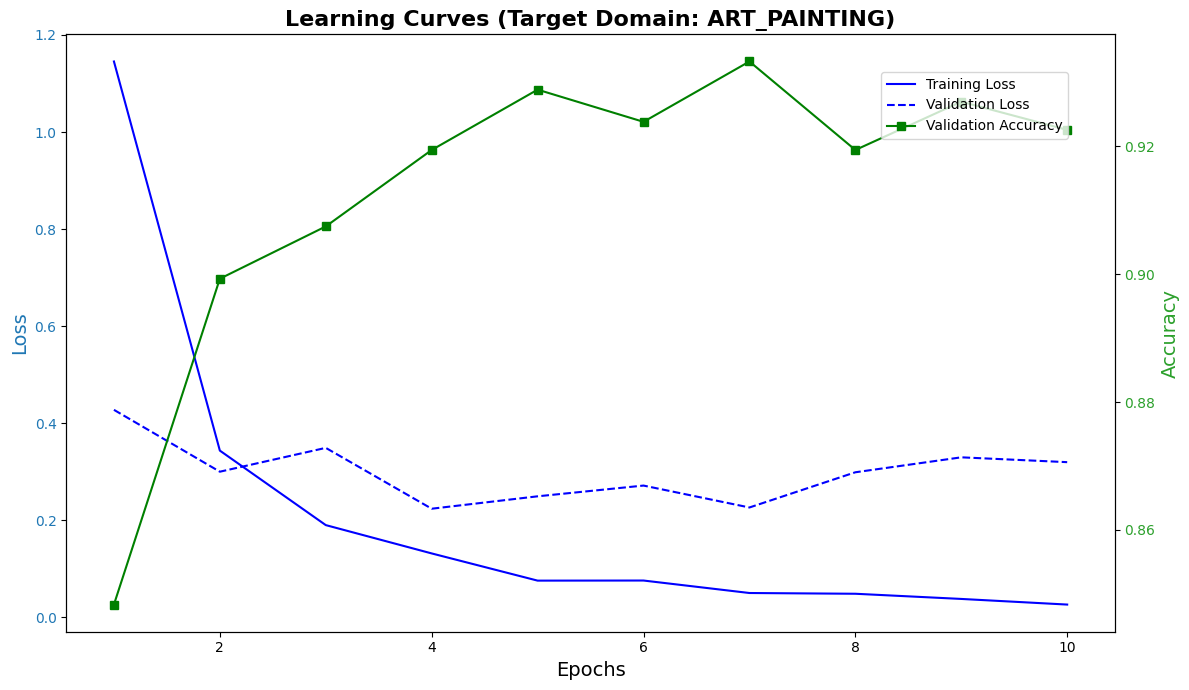

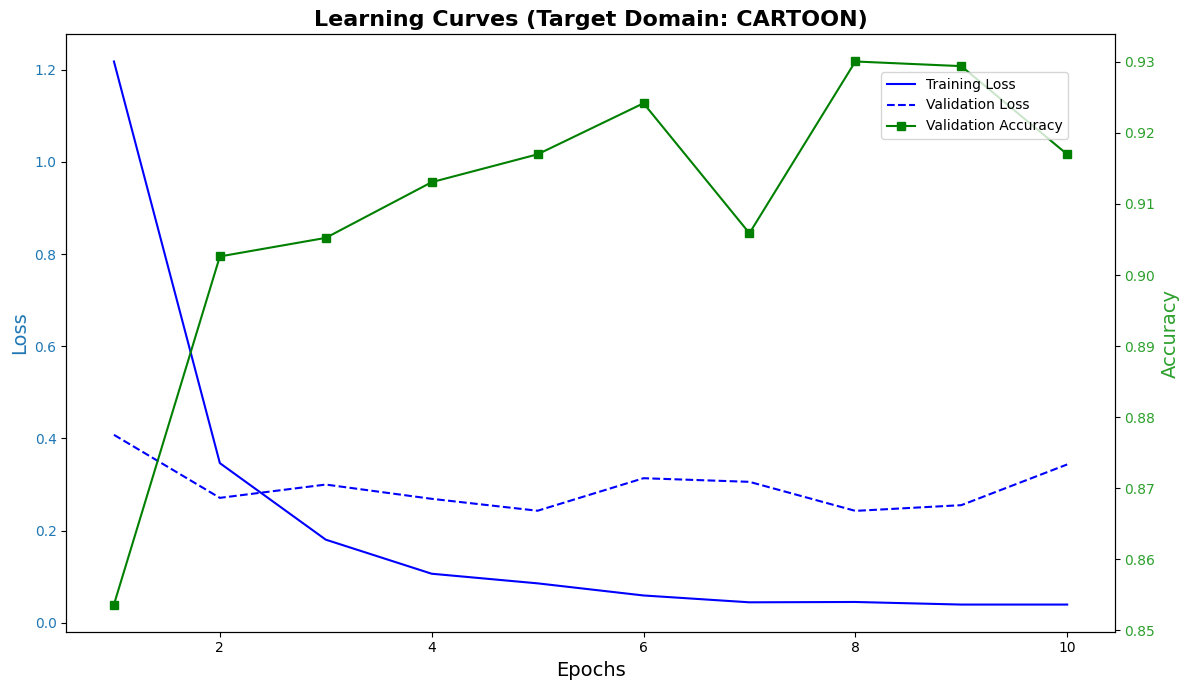

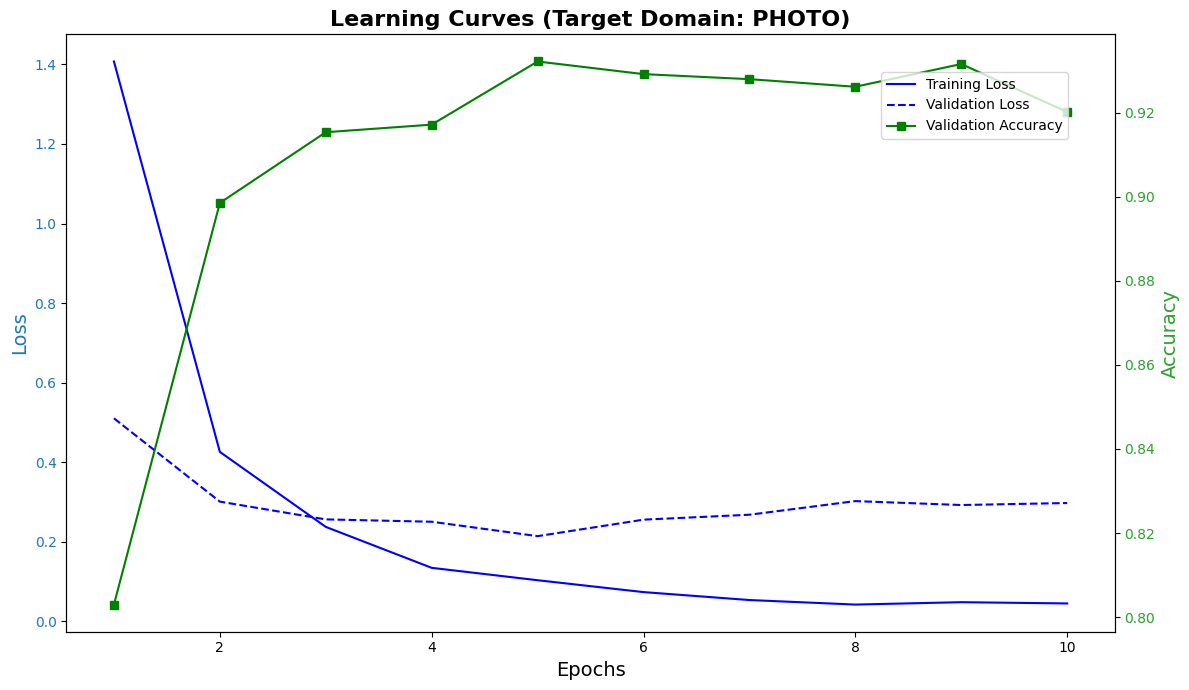

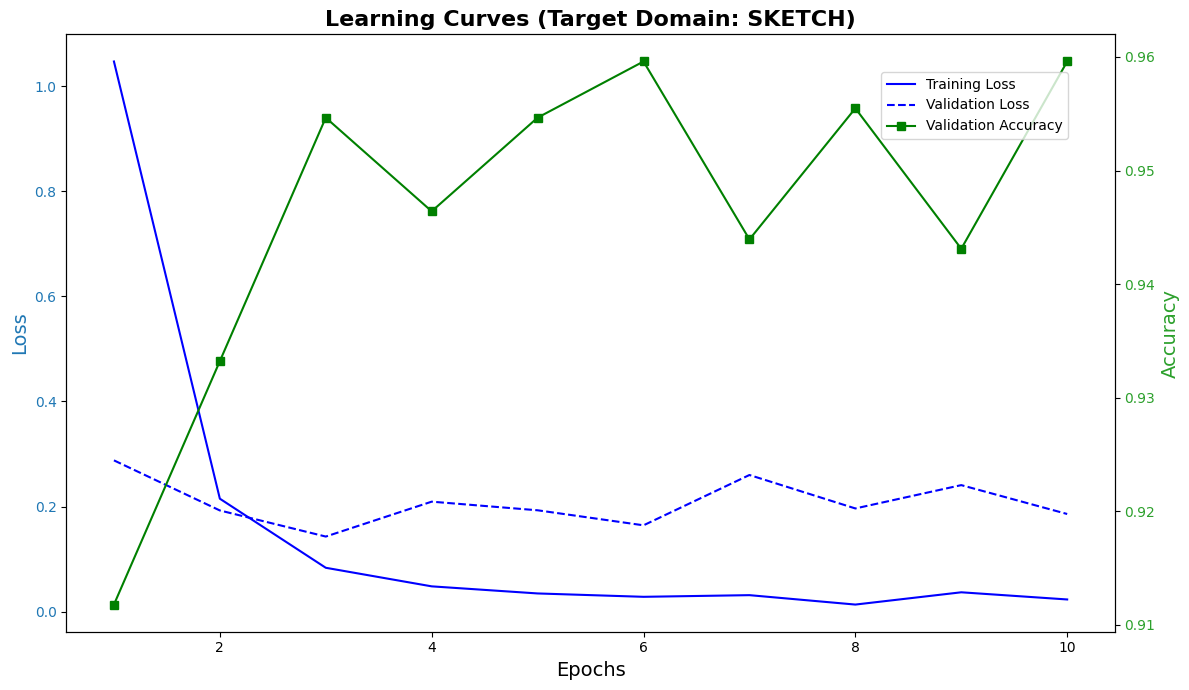

In [13]:
# =================================================================================
# SECTION 7: VISUALIZE LEARNING CURVES
# =================================================================================
print("\n" + "="*70)
print("--- Visualizing Learning Curves for Each LODO Experiment ---")
print("="*70)

for domain, history in lodo_histories.items():
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # Plotting losses on the primary y-axis
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14, color='tab:blue')
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'b--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Creating a secondary y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', fontsize=14, color='tab:green')
    ax2.plot(epochs, history['val_accuracy'], 'g-s', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    
    # Adding title and legends
    plt.title(f'Learning Curves (Target Domain: {domain.upper()})', fontsize=16, fontweight='bold')
    fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))
    
    fig.tight_layout()
    plt.show()

--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0  art_painting       0.808105           0.933291          10         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       cartoon       0.774744           0.930065          10         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         photo       0.950898           0.932132          10         128         0.0001  WinKawaks/vit-tiny-patch16-224
3        sketch       0.549249           0.959604          10         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7707


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_25528\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


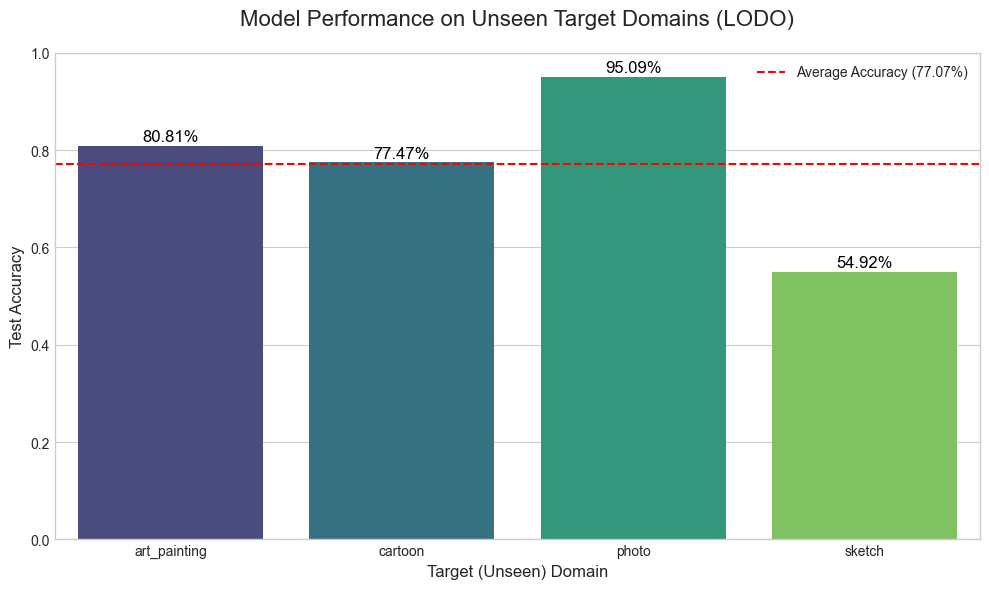


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
my_method_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.8081, 0.7747, 0.9509, 0.5492]
}

--- Experiment Complete ---


In [13]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")